In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
import pyro

from src.data.preprocessing import detrend, ffnn_input_vector
from src.models.paths import PROJECT_ROOT
from src.models.solid_earth_utils import greens_function, FFNN
from src.data.data_loader import load_uplift
from src.models.paths import PROJECT_ROOT
from src.models.pyro_custom import IntervalFoldedDistribution

print(PROJECT_ROOT)
pyro.set_rng_seed(42)
%load_ext autoreload
%autoreload 2

/data/eigil/work/premis


In [2]:
def compute_error(trues, predicted):
    '''
    From course material
    '''
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    return corr, mae, rae, rmse

In [3]:
Nr = np.arange(1, 7).tolist()
radius = [6371e3, 6341e3, 6311e3, 5951e3, 5701e3, 3480e3]
density = [3.037e3, 3.230e3, 3.438e3, 3.871e3, 4.978e3, 10.750e3]
rigidity = [0.50605e11, 0.50605e11, 0.70363e11, 1.05490e11, 2.28340e11, 0.0000e11]
bulk = [5.7437e10, 5.7437e10, 9.9633e10, 1.5352e11, 3.2210e11, 1.1018e12]
viscosity = [1.0e55, 1.0e21, 1.0e21, 1.0e21, 2.0e21, 0.0e21]

df_em = pd.DataFrame(
    np.array([Nr, radius, density, rigidity, bulk, viscosity]).T,
    columns=["Layer", "Radius [m]", "Density [kg/m^3]", "Rigidity [Pa]", "Bulk [Pa]", "Viscosity [Pa s]"],
)

lmax = 256
lmin = 0
lstep = 1
CONF = {
    "EARTH_FILE": "earth_M3L70V01c.txt",
    "COMPRESS": "1",
    "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
    "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
}

df = load_uplift()
height = df.Thickness.values
up_kuaq = df.Up_kuaq.values
up_mik2 = df.Up_mik2.values
df_em

/data/eigil/miniconda3/envs/premis/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


,Layer,Radius [m],Density [kg/m^3],Rigidity [Pa],Bulk [Pa],Viscosity [Pa s]
0,1.0,6371000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3230.0,5.060500e+10,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


In [4]:
# For modelling seasonality at some point

# X_time = np.concatenate([pd.get_dummies(df[x]) for x in ["dow", "tod"]], axis=1)
# pd.get_dummies(df["Time"])
# Make month columns
df1 = pd.concat([df, df.Time.dt.month], axis=1)
df1.columns = [*df1.columns[:-1], 'Month']
df1.head()

# make one hot encoding of month number
month_number = np.array(pd.get_dummies(df1["Month"]))

In [5]:
standardized_height = (height - np.mean(height) / np.std(height))
X_cat = np.concatenate([standardized_height[np.newaxis].T, month_number], axis=1)
X_train = torch.tensor(X_cat).float()

In [6]:
y_train1 = torch.tensor(detrend(up_kuaq)).float()
y_train1 = (y_train1 - y_train1.mean()) / y_train1.std()

y_train2 = torch.tensor(detrend(up_mik2)).float()
y_train2 = (y_train2 - y_train2.mean()) / y_train2.std()

y_train = torch.vstack([y_train1, y_train2]).T
y_train.shape

torch.Size([126, 2])

In [7]:
df_params = pd.read_csv("../data/processed/ffnn_variable_normalisation_params.csv")
x = ffnn_input_vector(df_em)

In [8]:
ffnn = FFNN(31, 200, 258)  # in shape, n hidden, out shape
ffnn.load_state_dict(torch.load("../models/ffnn_v0.pt"))
ffnn.eval()

FFNN(
  (in_layer): Linear(in_features=31, out_features=200, bias=True)
  (h1_layer): Linear(in_features=200, out_features=200, bias=True)
  (h2_layer): Linear(in_features=200, out_features=200, bias=True)
  (out_layer): Linear(in_features=200, out_features=258, bias=True)
  (relu): ReLU()
)

In [9]:
N = 126
sigma_w = pyro.sample("sigma", dist.Normal(torch.zeros(12), torch.ones(12)))
X_train[:, 1:].matmul(sigma_w)

tensor([-0.6967, -0.0686, -0.2438, -0.0786, -0.1666,  0.3015,  0.5413, -1.3299,
         0.9839,  1.0781, -0.8751, -0.2678, -0.6967, -0.0686, -0.2438, -0.0786,
        -0.1666,  0.3015,  0.5413, -1.3299,  0.9839,  1.0781, -0.8751, -0.2678,
        -0.6967, -0.0686, -0.2438, -0.0786, -0.1666,  0.3015,  0.5413, -1.3299,
         0.9839,  1.0781, -0.8751, -0.2678, -0.6967, -0.0686, -0.2438, -0.0786,
        -0.1666,  0.3015,  0.5413, -1.3299,  0.9839,  1.0781, -0.8751, -0.2678,
        -0.6967, -0.0686, -0.2438, -0.0786, -0.1666,  0.3015,  0.5413, -1.3299,
         0.9839,  1.0781, -0.8751, -0.2678, -0.6967, -0.0686, -0.2438, -0.0786,
        -0.1666,  0.3015,  0.5413, -1.3299,  0.9839,  1.0781, -0.8751, -0.2678,
        -0.6967, -0.0686, -0.2438, -0.0786, -0.1666,  0.3015,  0.5413, -1.3299,
         0.9839,  1.0781, -0.8751, -0.2678, -0.6967, -0.0686, -0.2438, -0.0786,
        -0.1666,  0.3015,  0.5413, -1.3299,  0.9839,  1.0781, -0.8751, -0.2678,
        -0.6967, -0.0686, -0.2438, -0.07

In [10]:
np.hstack((80, df_em["radius"].values, 
           df_em["density"].values, 
           df_em["rigidity"].values, 
           df_em["bulk"].values,
           df_em["viscosity"].values))

array([8.0000e+01, 6.3710e+06, 6.3410e+06, 6.3110e+06, 5.9510e+06,
       5.7010e+06, 3.4800e+06, 3.0370e+03, 3.2300e+03, 3.4380e+03,
       3.8710e+03, 4.9780e+03, 1.0750e+04, 5.0605e+10, 5.0605e+10,
       7.0363e+10, 1.0549e+11, 2.2834e+11, 0.0000e+00, 5.7437e+10,
       5.7437e+10, 9.9633e+10, 1.5352e+11, 3.2210e+11, 1.1018e+12,
       1.0000e+55, 1.0000e+21, 1.0000e+21, 1.0000e+21, 2.0000e+21,
       0.0000e+00])

In [19]:
def model(X, x, df_params, obs=None, df_em=None):
    # densities at index 7 and 8
    N = len(X)
    seasonality = 12 # months
    t = torch.linspace(0, 1, N)

    alpha_w = pyro.sample("alpha_v", dist.Normal(0., 1.))
    sigma_w = pyro.sample("sigma", dist.Normal(torch.zeros(seasonality, 2), torch.ones(seasonality, 2)))
    
    # rigidity layer 1 & 2
    # loc, scale = torch.ones(2) * 0, torch.ones(2) * 1
    #rigidity_dist = IntervalFoldedDistribution(dist.Normal(loc, scale), lower=2 * 1e-2, upper=2 * 5e1)
    # rigidity = 1e11 + 1e10 * pyro.sample("rigidity", dist.Normal(loc, scale))

    # x[14] = (rigidity[0] - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]
    # x[15] = (rigidity[1] - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]
    
    # rigidity layer 1
    loc, scale = 0, 1
    rigidity_1 = 1e10 + 1e10 * pyro.sample("rigidity_1", dist.Normal(loc, scale))

    # rigidity layer 2
    loc, scale = 0, 1
    rigidity_2 = 1e10 + 1e10 * pyro.sample("rigidity_2", dist.Normal(loc, scale))

    x[14] = (rigidity_1 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]
    x[15] = (rigidity_2 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]
    

    hlove = ffnn(x).detach().numpy()
    nlove = len(hlove)
    
    # Draw Greens Function
    gf_kuaq = greens_function(
        hlove,
        nlove,
        [68.704665, -33.214577],
        [68.58700000, -33.05270000],
        arsurf=80e3 * 80e3,
    )
    gf_mik2 = greens_function(
        hlove,
        nlove,
        [68.704665, -33.214577],
        [68.14029705, -31.45179999],
        arsurf=80e3 * 80e3,
    )
    gf = pyro.deterministic("gf", torch.tensor([gf_kuaq, gf_mik2]))

    # Draw target
    with pyro.plate("data", 2):
        w = pyro.sample("w", dist.Normal(- gf * X[:, 0][..., None], torch.exp(alpha_w + X[:, 1:].matmul(sigma_w))))
    
    return w

In [20]:
# import os
# os.environ["OMP_NUM_THREADS"] = '1'
# Run inference in Pyro

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)
mcmc.run(X_train, x, df_params, y_train, df_em)

Warmup:   1%|          | 9/1100 [00:36,  5.31s/it, step size=2.26e-04, acc. prob=0.546]

: 

: 

In [13]:
with open('file.pkl', 'wb') as f:
	dill.dump(supervised_posterior, f)
with open('file.pkl', 'rb') as f:
	supervised_posterior = dill.load(f)

NameError: name 'dill' is not defined

In [14]:
# Show summary of inference results
mcmc.summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha_v     -0.44      0.59     -0.42     -1.48      0.42      5.81      1.27
  rigidity_1      0.01      0.53      0.01     -0.84      0.87    891.80      1.00
  rigidity_2     -0.01      1.09     -0.03     -1.72      1.90    616.74      1.00
  sigma[0,0]      0.20      0.82      0.09     -1.16      1.49     25.73      1.03
  sigma[0,1]     -0.03      1.01     -0.01     -1.71      1.52     29.10      1.00
  sigma[1,0]      0.37      0.98      0.42     -1.37      1.81     32.56      1.04
  sigma[1,1]      0.11      0.97      0.07     -1.46      1.66     21.40      1.00
  sigma[2,0]     -0.16      1.00     -0.28     -1.79      1.52     26.04      1.02
  sigma[2,1]      0.04      0.89     -0.03     -1.45      1.52     26.90      1.04
  sigma[3,0]      0.07      0.91      0.06     -1.44      1.59     43.88      1.01
  sigma[3,1]     -0.26      0.97     -0.19     -1.87      1.26     14.71      1.14
  s

In [15]:
#### compare to PREM
# from table IV
depths = abs(df_em["radius"].values - df_em.loc[0, "radius"]) / 1e3 # in km
depth_table = np.array([0, 3, 15, 24, 40, 60, 80])
A = np.array([21, 875, 1341, 2268, 2260, 2251, 2242])
C = np.array([21, 875, 1341, 2176, 2165, 2151, 2138])
L = np.array([0, 266, 441, 653, 654, 655, 656])
N = np.array([0, 266, 441, 719, 714, 708, 702])
F = np.array([21, 342, 459, 866, 863, 860, 857])

prem_rigidity_1 = np.mean(1 / 15 * (A[:4] + C[:4] - 2 * F[:4] + 5 * N[:4] + 6 * L[:4]))
prem_rigidity_2 = np.mean(1 / 15 * (A[4:6] + C[4:6] - 2 * F[4:6] + 5 * N[4:6] + 6 * L[4:6]))
prem_rigidity = {"rigidity_1" : prem_rigidity_1 * 1e8, "rigidity_2" : prem_rigidity_2 * 1e8}

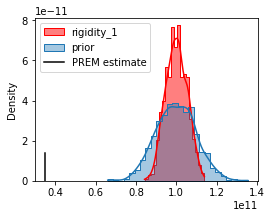

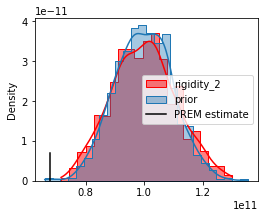

In [17]:
samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["rigidity_1", "rigidity_2"]

rigidity_dist_prior = dist.Normal(torch.zeros(1000), 1)
rigidity_prior = 1e11 + 1e10 * pyro.sample("rigidity_prior", rigidity_dist_prior)

for node in nodes:
    plt.figure(figsize=(4, 3))
    g = sns.histplot(
        1e11 + 1e10 * samples[node],
        label=node,
        kde=True,
        stat="density",
        element="step",
        color="red",
    )
    sns.histplot(
        rigidity_prior,
        label="prior",
        kde=True,
        stat="density",
        element="step",
        alpha=0.4,
    )
    plt.axvline(prem_rigidity[node], 0, 0.17, color="black", label="PREM estimate")
    plt.legend()
    plt.show()

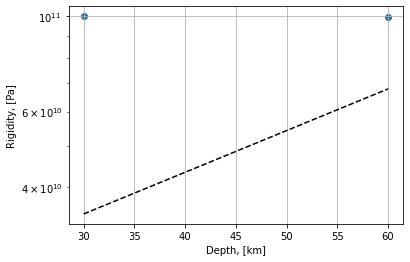

In [18]:
rigidity_list = []
prem_rigidity_list = []
for node in nodes:
    rigidity_list.append(1e11 + 1e10 * samples[node].mean())
    prem_rigidity_list.append(prem_rigidity[node])
   
x_depth = [30, 60] 
plt.scatter(x_depth, rigidity_list, label="Modelled rigidities")
plt.plot(x_depth, prem_rigidity_list, color='black', linestyle='--', label='PREM estimate')
plt.yscale('log')
plt.xlabel("Depth, [km]")
plt.ylabel("Rigidity, [Pa]")
plt.grid()

### Compare to observations

In [56]:
from pyro.infer import Predictive

predictive = Predictive(model, samples)(X_train, x, df_params, y_train, df_em)
for k, v in predictive.items():
    print(f"{k}: {tuple(v.shape)}")

gf: (1000, 1)
w: (1000, 126)


corr = 0.31417021313723364, 
mae = 1.4562737941741943, 
rae = 1.8080215454101562, 
rmse = 1.8920226097106934


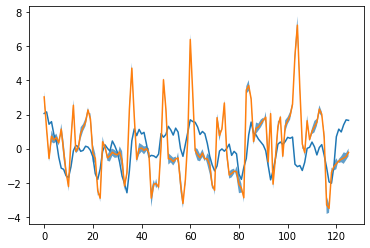

In [76]:
seasonal_error = X_train[:, 1:].matmul(samples['sigma'].mean(axis=0))

w_pred = (- predictive["gf"] * X_train[:, 0]).mean(axis=0)
w_above = w_pred + seasonal_error
w_below = w_pred - seasonal_error

plt.plot(y_train)
plt.plot(w_pred)
plt.fill_between(range(126), w_below, w_above, alpha=0.7)
corr, mae, rae, rmse = compute_error(y_train.numpy(), w_pred.numpy())
print(f"corr = {corr}, \nmae = {mae}, \nrae = {rae}, \nrmse = {rmse}")

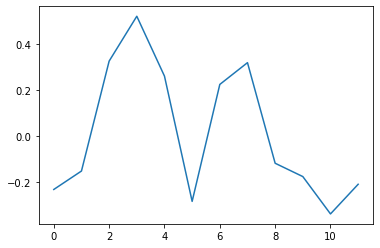

In [78]:
# error per month
plt.plot(samples["sigma"].mean(axis=0))

## Different things from earlier work

In [ ]:
dont run the next cells

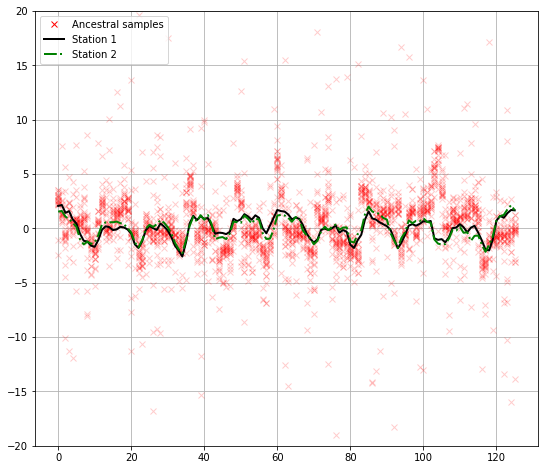

In [ ]:
plt.figure(figsize=(9, 8))
for i in range(10):
    sampling = model(X_train, x, df_params, y_train, df_em)
    plt.plot(sampling, marker="x", linestyle="None", alpha=0.2, color="red")
    
plt.plot(sampling[:, 0], marker="x", linestyle="None", alpha=0.2, color="red", label="Ancestral samples")
plt.plot(y_train[:, 0], linewidth=2, color="black", label="Station 1")
plt.plot(y_train[:, 1], linewidth=2, linestyle="-.", color="green", label="Station 2")
plt.ylim([-20, 20])
plt.legend()
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_alpha(1)
plt.grid()
plt.savefig("./ancestral_sampling.png", dpi=500)

In [ ]:
# saves the model and optimizer states to disk
def save_checkpoint(model):
    log("saving model to %s..." % args.save_model)
    torch.save(dmm.state_dict(), args.save_model)
    log("saving optimizer states to %s..." % args.save_opt)
    optimizer.save(args.save_opt)
    log("done saving model and optimizer checkpoints to disk.")

# loads the model and optimizer states from disk
def load_checkpoint():
    assert exists(args.load_opt) and exists(args.load_model), \
        "--load-model and/or --load-opt misspecified"
    log("loading model from %s..." % args.load_model)
    dmm.load_state_dict(torch.load(args.load_model))
    log("loading optimizer states from %s..." % args.load_opt)
    optimizer.load(args.load_opt)
    log("done loading model and optimizer states.")

dict_keys(['rigidity_1', 'rigidity_2', 'sigma'])

In [ ]:
class TruncatedNormal(dist.Rejector):
    def __init__(self, loc, scale_0, max_x0):
        propose = dist.Normal(loc, scale_0)

        def log_prob_accept(x):
            return (x[0] < max_x0).type_as(x).log()

        log_scale = torch.tensor(dist.LogNormal(loc, scale_0).cdf(max_x0)).log()
        super(TruncatedLogNormal, self).__init__(propose, log_prob_accept, log_scale)

In [ ]:
## TODO: For guide support, see: https://forum.pyro.ai/t/truncated-log-normal-distribution/2002
# from torch.distributions import constraints

# class TruncatedLogNormal(dist.Rejector):
#     ...
#     @constraints.dependent_property
#     def support(self):
#         return constraints.interval(0, self.max_x0)

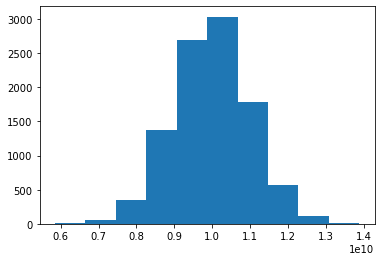

In [ ]:
diste = IntervalFoldedDistribution(dist.Normal(1e10*torch.ones(10000), 1e9), lower=1e8, upper=1e12)
plt.hist(np.array(pyro.sample("test", diste)));

tensor(0.)

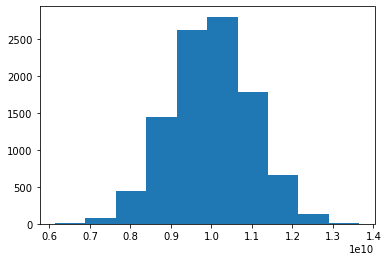

In [ ]:
samples = 1e10 * pyro.sample("test", dist.Normal(torch.ones(10000), 0.1))
plt.hist(np.array(samples));
samples[samples < 1e8].sum()

In [ ]:
import numpyro
import numpyro.distributions as np_dist
from numpyro.infer import MCMC, NUTS

def model():

    # sample1 = numpyro.sample("rigidity1", bounded_rig1)
    rigidity_unscaled = numpyro.sample("rigidity_unscaled", np_dist.Normal(0, 1))
    
    rigidity_scaled = numpyro.deterministic("rigidity_scaled", 1e10 + 1e9 * rigidity_unscaled)
    # rigidity_scaled = numpyro.sample("rigidity_scaled", np_dist.Uniform(1e9, 1e11))

    
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
num_samples = 10000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(rng_key_)

print(mcmc.get_samples()["rigidity_scaled"].min() , mcmc.get_samples()["rigidity_scaled"].mean(), mcmc.get_samples()["rigidity_scaled"].max())

sample: 100%|██████████| 11000/11000 [00:14<00:00, 774.53it/s, 3 steps of size 1.26e+00. acc. prob=0.89]


-3806359800.0 -24906074.0 4083562800.0


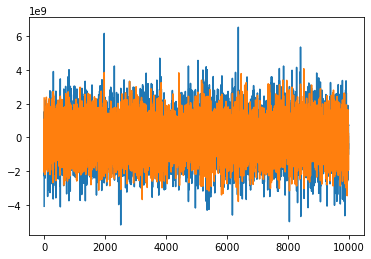

In [ ]:
samples = mcmc.get_samples()["rigidity_scaled"].to_py()
plt.plot(np.diff(samples))
plt.plot(samples)

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

def model(height, obs=None, df_em=None):
    sample1 = pyro.sample("rigidity1", dist.Normal(1, 1e-1))

# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1, num_chains=1)
mcmc.run(X_train, y_train, df_em)

print(mcmc.get_samples()["rigidity1"].min() , mcmc.get_samples()["rigidity1"].mean(), mcmc.get_samples()["rigidity1"].max())

Sample: 100%|██████████| 1001/1001 [12:24,  1.34it/s, step size=1.16e-10, acc. prob=1.000]

tensor(0.8238) tensor(0.9997) tensor(1.)
